In [1]:
import pickle
import numpy as np
import scipy.stats as stats
import math
import json

In [2]:
model = "Qwen3-1.7B"

In [3]:
with open("/data/home/vkropoti/sql_data/mini-dev-index", "rb") as fp:   # Unpickling
    mini_dev_index = np.array(pickle.load(fp))
    
def load_json():
    with open('/home/vkropoti/vllm/dev.json', "r") as j:
        contents = json.loads(j.read())
    return contents

def load_split():
    data = load_json()
    query_level = []
    for k in range(len(data)):
        query_level.append(data[k]['difficulty'])
    return np.array(query_level)

In [4]:
split = load_split()

In [5]:
np.mean(split=='simple')

np.float64(0.6029986962190352)

In [6]:
np.mean(split=='moderate')

np.float64(0.30247718383311606)

In [7]:
np.mean(split=='challenging')

np.float64(0.09452411994784876)

In [8]:
def I_alpha(mean,n,std_dev,confidence = 0.95):
    # Критическое значение t для 95% ДИ и 49 степеней свободы
    t_value = stats.t.ppf((1 + confidence) / 2, df=n-1)
    margin_of_error = t_value * (std_dev / math.sqrt(n))
    
    # Границы доверительного интервала
    ci_lower = mean - margin_of_error
    ci_upper = mean + margin_of_error
    return ci_lower, ci_upper

In [9]:
def load_results(k,nobs,cot_type,think=False):
    # sql_results_Qwen3-8B-cot_all_new_think==False_nobs2-v0
    # with open(f"/data/home/vkropoti/sql_llm_answers/base_reasoning/sql_results_{model}-cot_{type_cot}_think=={use_think}-v{k}", "rb") as fp:
    with open(f"/data/home/vkropoti/sql_llm_answers/spider_dev_m_schema/sql_results_Qwen3-1.7B-cot_{cot_type}_think=={think}_nobs{nobs}-v{k}", "rb") as fp:
        results = np.array(pickle.load(fp))
    return results

In [10]:
def load_executed(k,nobs,cot_type,think=False):
    # /data/home/vkropoti/sql_llm_answers/base_reasoning/sql_executed_{model}-cot_{type_cot}_think=={use_think}-v{version}
    with open(f"/data/home/vkropoti/sql_llm_answers/spider_dev_m_schema/sql_executed_Qwen3-1.7B-cot_{cot_type}_think=={think}_nobs{nobs}-v{k}", "rb") as fp:
        executed = np.array(pickle.load(fp))
    return executed

In [11]:
def get_think_results(n,nobs=2,cot_type='all_new',think=False):
    
    arr_mean_scores = []
    arr_mean_executed = []
    # d_split = {"simple":[], "moderate":[], "challenging":[]}
    for i in range(n):
        result, executed = load_results(i,nobs,cot_type,think), load_executed(i,nobs,cot_type,think)
        arr_mean_scores.append(np.mean(result))
        arr_mean_executed.append(np.mean(executed))
        # d_split['simple'].append(np.mean(result[split=='simple']))
        # d_split['moderate'].append(np.mean(result[split=='moderate']))
        # d_split['challenging'].append(np.mean(result[split=='challenging']))
        
    if cot_type=='all_new':
        add = "данные о размышлениях + финальный ответ"
    elif cot_type=='think':
        add = "только данные о размышлениях"
    elif cot_type=='predict':
        add = "только данные о финальных ответах"

    ci_lower, ci_upper = I_alpha(np.mean(np.array(arr_mean_scores)),n,np.std(np.array(arr_mean_scores)))
    print(f"Модель основывает ответ по {nobs} выводам других моделей, которые включают {add}")
    print(f"Результаты получены прогоном {n} симуляций с разными seed")
    print(f"{model} DEV Финальный результат EX: {np.mean(np.array(arr_mean_scores)):.5f}, при std: {np.std(np.array(arr_mean_scores)):.4f}")
    print(f"95% доверительный интервал: ({ci_lower:.5f},{ci_upper:.5f})")
    # for type_ in d_split:
    #     print(f"{type_}: {np.mean(np.array(d_split[type_])):.5f}")
    # print(f"{model} процент запросов, которые успешно выполнились DEV: {np.mean(np.array(arr_mean_executed)):.4f}, при std: {np.std(np.array(arr_mean_executed)):.4f}")
    return np.mean(np.array(arr_mean_scores))
    # print(f"{model} процент запросов, которые успешно выполнились Mini DEV: {np.mean(np.array(arr_mean_executed)):.4f}, при std: {np.std(np.array(arr_mean_executed)):.4f}")
    

## Использование reasoning+ответ

In [12]:
scores = []
for n in range(2,6):
    scores.append(get_think_results(20,nobs=n,cot_type='all_new'))
    print()

Модель основывает ответ по 2 выводам других моделей, которые включают данные о размышлениях + финальный ответ
Результаты получены прогоном 20 симуляций с разными seed
Qwen3-1.7B DEV Финальный результат EX: 0.70381, при std: 0.0047
95% доверительный интервал: (0.70161,0.70601)

Модель основывает ответ по 3 выводам других моделей, которые включают данные о размышлениях + финальный ответ
Результаты получены прогоном 20 симуляций с разными seed
Qwen3-1.7B DEV Финальный результат EX: 0.70939, при std: 0.0053
95% доверительный интервал: (0.70692,0.71185)

Модель основывает ответ по 4 выводам других моделей, которые включают данные о размышлениях + финальный ответ
Результаты получены прогоном 20 симуляций с разными seed
Qwen3-1.7B DEV Финальный результат EX: 0.71408, при std: 0.0058
95% доверительный интервал: (0.71137,0.71679)

Модель основывает ответ по 5 выводам других моделей, которые включают данные о размышлениях + финальный ответ
Результаты получены прогоном 20 симуляций с разными seed

## Использование только ответ

In [13]:
scores_predict = []
for n in range(2,6):
    scores_predict.append(get_think_results(20,nobs=n,cot_type='predict'))
    print()

Модель основывает ответ по 2 выводам других моделей, которые включают только данные о финальных ответах
Результаты получены прогоном 20 симуляций с разными seed
Qwen3-1.7B DEV Финальный результат EX: 0.69345, при std: 0.0068
95% доверительный интервал: (0.69028,0.69662)

Модель основывает ответ по 3 выводам других моделей, которые включают только данные о финальных ответах
Результаты получены прогоном 20 симуляций с разными seed
Qwen3-1.7B DEV Финальный результат EX: 0.69893, при std: 0.0065
95% доверительный интервал: (0.69589,0.70197)

Модель основывает ответ по 4 выводам других моделей, которые включают только данные о финальных ответах
Результаты получены прогоном 20 симуляций с разными seed
Qwen3-1.7B DEV Финальный результат EX: 0.70000, при std: 0.0066
95% доверительный интервал: (0.69693,0.70307)

Модель основывает ответ по 5 выводам других моделей, которые включают только данные о финальных ответах
Результаты получены прогоном 20 симуляций с разными seed
Qwen3-1.7B DEV Финальны

## Использование только размышлений

In [14]:
scores_think = []
for n in range(2,6):
    scores_think.append(get_think_results(20,nobs=n,cot_type='think'))
    print()

Модель основывает ответ по 2 выводам других моделей, которые включают только данные о размышлениях
Результаты получены прогоном 20 симуляций с разными seed
Qwen3-1.7B DEV Финальный результат EX: 0.70177, при std: 0.0066
95% доверительный интервал: (0.69867,0.70486)

Модель основывает ответ по 3 выводам других моделей, которые включают только данные о размышлениях
Результаты получены прогоном 20 симуляций с разными seed
Qwen3-1.7B DEV Финальный результат EX: 0.70901, при std: 0.0060
95% доверительный интервал: (0.70619,0.71184)

Модель основывает ответ по 4 выводам других моделей, которые включают только данные о размышлениях
Результаты получены прогоном 20 симуляций с разными seed
Qwen3-1.7B DEV Финальный результат EX: 0.71073, при std: 0.0064
95% доверительный интервал: (0.70772,0.71374)

Модель основывает ответ по 5 выводам других моделей, которые включают только данные о размышлениях
Результаты получены прогоном 20 симуляций с разными seed
Qwen3-1.7B DEV Финальный результат EX: 0.71

In [20]:
scores - 

[np.float64(0.7038104089219331),
 np.float64(0.7093866171003717),
 np.float64(0.7140799256505577),
 np.float64(0.7139869888475835)]

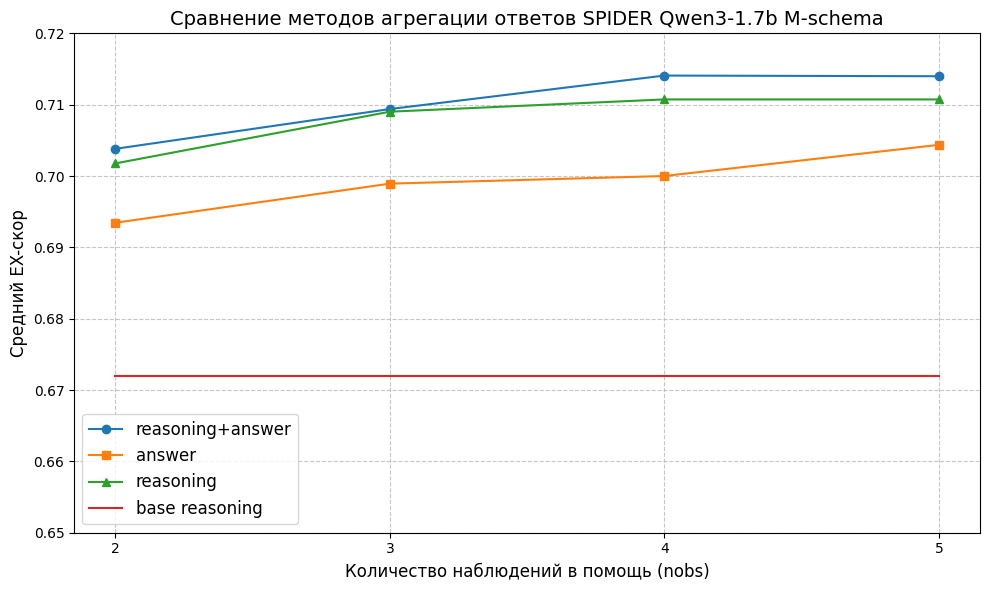

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Данные
nobs = [2, 3, 4, 5]
base_think = [0.672]*4
# Создание графика
plt.figure(figsize=(10, 6))
plt.plot(nobs, scores, marker='o', label='reasoning+answer', color='tab:blue')
plt.plot(nobs, scores_predict, marker='s', label='answer', color='tab:orange')
plt.plot(nobs, scores_think, marker='^', label='reasoning', color='tab:green')
plt.plot(nobs, base_think, label='base reasoning', color='tab:red')

# Настройки
plt.title('Сравнение методов агрегации ответов SPIDER Qwen3-1.7b M-schema', fontsize=14)
plt.xlabel('Количество наблюдений в помощь (nobs)', fontsize=12)
plt.ylabel('Средний EX-скор', fontsize=12)
plt.xticks(nobs)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.ylim(0.65, 0.72)  # Фиксируем диапазон для лучшего сравнения
plt.grid(visible=True)
# Отображение
plt.tight_layout()

plt.show()